# Fixing the ISR for PhoSim simulated images for AOS 


The **outline** of the process of making calibs / ingesting calibs / ingesting raw images / running the ISR task on these images in the current AOS pipeline: 

* currently fake flats are made with `/astro/store/epyc/projects/lsst_comm/phosim_utils/bin/makeGainImages.py` from https://github.com/lsst-dm/phosim_utils/blob/master/bin.src/makeGainImages.py It is called via `baseComcamLoop.py` `_makeCalibs()` command.  For ComCam, this runs the command:

    makeGainImages.py --detector_list R22_S00 R22_S01 R22_S02 R22_S10 R22_S11 R22_S12 R22_S20 R22_S21 R22_S22
    
    
* the calibs are ingested via `WEPCalculation.ingestCalibs()`  https://github.com/lsst-ts/ts_wep/blob/9b7d23d071729b88e17d69f81f7d519c59d838fe/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py#L681   that calls `dataCollector.ingestCalibs()` https://github.com/lsst-ts/ts_wep/blob/9b7d23d071729b88e17d69f81f7d519c59d838fe/python/lsst/ts/wep/CamDataCollector.py#L29  with ` /astro/store/epyc/projects/lsst_comm/stack_w_2020_24/stack/miniconda3-4.7.12-1a1d771/Linux64/pipe_tasks/19.0.0-63-gd25ffe2a/python/lsst/pipe/tasks/ingestCalibs.py` from https://github.com/lsst/pipe_tasks/blob/master/python/lsst/pipe/tasks/ingestCalibs.py. That produces the command of the following form using the `ingestCalibs` task : 

    ingestCalibs.py destinationDir  pathToFakeFlats/* --validity 99999 --output  destinationDir
    
* then the repackaged PhoSim raw images are ingested with the `ingestImages` task `/epyc/projects/lsst_comm/stack_w_2020_24/stack/miniconda3-4.7.12-1a1d771/Linux64/pipe_tasks/19.0.0-63-gd25ffe2a/python/lsst/pipe/tasks/ingest.py` 
(need: `_mapper` file)  https://github.com/lsst/pipe_tasks/blob/master/python/lsst/pipe/tasks/ingest.py  called from `baseComcamLoop` with `wepCalc._ingestImg(rawExpData)`:

    ingestImages.py destinationDir  rawImagesDir/*_a_*.fits*
     
* the ISR is performed `runIsr` task https://github.com/lsst/ip_isr/blob/master/python/lsst/ip/isr/isrTask.py , called from within `WEPCalculation.py` by `wepCalc._doIsr()`. The `isr_config.py` file is created as part of that command. The command run is of this format:
    
    runIsr.py destinationDir --id --rerun=run1 --configfile destinationDir/isr_config.py --no-versions
    
which calls :

    from lsst.ip.isr.isrTask import RunIsrTask
    RunIsrTask.parseAndRun()
    
and the output directory is for instance : 
    
    destinationDir  = results_gaia/dr2_low_full_2020_24/input  

**Executive summary**
- I first explain the **problem**: how flats were made before, and what was the problem in using them for ISR
- I implement the **solution**: change in the orientation of the flats 
- I show a quick 'by-hand' ISR that uses values for bias and gain from headers of raw FITS files
- I show the result of running ISR with just overscan, 
- I show the improvement of running ISR with overscan and updated flats, which is the recommended default setting for `ts_wep` 

## The problem: making fake flats with incorrect orientation

In [6]:
from lsst.obs.lsst.phosim import PhosimMapper
import lsst.afw.image as afwImage
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os  

Code below is from https://github.com/lsst-dm/phosim_utils/blob/master/bin.src/makeGainImages.py before the update

I only make the flat for one sensor: `R22_S00` to illustrate the problem

In [2]:

# we make example flat for R22_S00 sensor for comcam 
detector_list = ["R22_S00"]#, "R22_S01", "R22_S02", "R22_S10", "R22_S11",
                # "R22_S12", "R22_S20", "R22_S21", "R22_S22"]
camera = PhosimMapper().camera
ccd = camera["R22_S00"]
filt_name = 'g'
name = ccd.getName()
print(name)
CHIPID = "".join([c for c in name if c != "," and c != ":"])
CHIPID = "_".join(CHIPID.split())
image = afwImage.ImageF(ccd.getBBox())
for amp in ccd:
    subim = afwImage.ImageF(image, amp.getBBox())
    subim[:] = 1/amp.getGain()
    print(amp.getName(), amp.getGain())
expInfo = afwImage.ExposureInfo()
inFilter = afwImage.Filter(filt_name)
expInfo.setFilter(inFilter)
exp = afwImage.ExposureF(afwImage.MaskedImageF(image), expInfo)
md = exp.getMetadata()
md.set('CHIPID', CHIPID)
# Set place holder date
md.set('MJD-OBS', 53005.0)

R22_S00
C10 1.719
C11 1.716
C12 1.653
C13 1.78
C14 1.735
C15 1.678
C16 1.678
C17 1.732
C07 1.705
C06 1.671
C05 1.764
C04 1.606
C03 1.622
C02 1.729
C01 1.641
C00 1.706


The outcome is as follows: 

Text(0.5, 1.0, 'R22_S00')

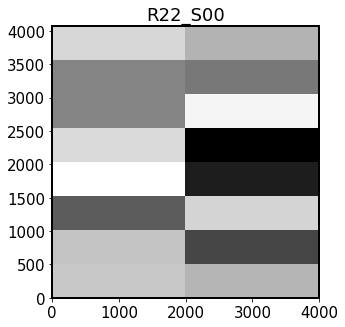

In [3]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(exp.image.array.T, origin='lower',cmap='Greys')
ax.set_title(name)

Make flats with that code and run the ISR: 

In [41]:
from lsst.obs.lsst.phosim import PhosimMapper
import lsst.afw.image as afwImage

from datetime import datetime
def makeGainImages(just_wfs=False, detector_list=None):

    if (just_wfs is True) and (detector_list is not None):
        raise RuntimeError("--just_wfs and --detector_list are exclusive.")

    camera = PhosimMapper().camera
    if just_wfs:
        ccd_list = [camera[name] for name in ["R00_S22", "R04_S20", "R44_S00", "R40_S02"]]
    elif (detector_list is not None):
        ccd_list = [camera[name] for name in detector_list]
    else:
        ccd_list = camera

    for filt_name in 'ugrizy':
        for ccd in ccd_list:
            name = ccd.getName()
            # I'm not sure how to deal with the split chips yet.
            if 'A' in name or 'B' in name:
                continue
            print(name)
            CHIPID = "".join([c for c in name if c != "," and c != ":"])
            CHIPID = "_".join(CHIPID.split())
            image = afwImage.ImageF(ccd.getBBox())
            for amp in ccd:
                subim = afwImage.ImageF(image, amp.getBBox())
                subim[:] = 1/amp.getGain()
                #print(amp.getName(), amp.getGain())

            expInfo = afwImage.ExposureInfo()
            inFilter = afwImage.Filter(filt_name)
            expInfo.setFilter(inFilter)
            exp = afwImage.ExposureF(afwImage.MaskedImageF(image), expInfo)
            md = exp.getMetadata()
            md.set('CHIPID', CHIPID)
            # Set place holder date
            md.set('MJD-OBS', 53005.0)
            md.set('OBSTYPE', 'flat')
            # arbitrary for flats
            md.set('EXPTIME', 100)
            # need to be able to specify any filter
            md.set('CALDATE', 53005.0)
            # Add the CALIB_ID header card
            md.set('CALIB_ID', 'raftName=%s detectorName=%s detector=%i filter=%s calibDate=%s' %
                   (CHIPID.split('_')[0], CHIPID.split('_')[1], ccd.getId(), filt_name, datetime.now()))
            exp.setMetadata(md)
            exp.writeFits("%(name)s_%(filter)s.fits"%({'name': CHIPID, 'filter': filt_name}))


import numpy as np 
# the following is from baseComCamLoop.py 
# https://github.com/lsst-ts/ts_phosim/blob/25ac8cdb8d8be394c18e16e66d291fecd1e3922d/notebooks/analysis_scripts/baseComcamLoop.py#L689
outputDir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/'
fakeFlatDirName = "fake_flats"
fakeFlatDir = os.path.join(outputDir, fakeFlatDirName)
if (not os.path.exists(fakeFlatDir)):    
    os.makedirs(fakeFlatDir)
    
# record where we are 
currWorkDir = os.getcwd()

# move to fake flat dir 
os.chdir(fakeFlatDir)
detector_list = ["R22_S00", "R22_S01", "R22_S02", "R22_S10", "R22_S11",
          "R22_S12", "R22_S20", "R22_S21", "R22_S22"]
makeGainImages(detector_list=detector_list)

# return to the original dir 
os.chdir(currWorkDir)

print('Done')

R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22


Ingest the calibs:

In [42]:
calibFiles = os.path.join(fakeFlatDir, "*")
command = "ingestCalibs.py"

argstring = "%s %s --validity 99999 --output %s" % (
            input_dir, calibFiles, input_dir)
import subprocess


cmd = ['ingestCalibs.py',input_dir, calibFiles, '--validity 99999',
        '--output', input_dir]

a = ''
for x in cmd:
    a += ' %s '% x
print('The command run by subprocess is ')
print('\n',a)

proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = proc.communicate()



The command run by subprocess is 

  ingestCalibs.py  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/fake_flats/*  --validity 99999  --output  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/ 


## 1: ISR with old flats

In [47]:
isrSettings = {'doBias':False, 'doDark':False,
              'doFlat':True, 
              'doFringe':False, 'doDefect':False,
             }
content = ""
for setting in isrSettings.keys():
    content += "config.isr.%s=%s\n"%(setting,str(isrSettings[setting]))
isrConfigFname =  'isr_config.py'
config_path = os.path.join(input_dir,isrConfigFname)

# Write into file
fid = open(config_path, "w")
fid.write(content)
fid.close()

import subprocess

cmd = ['runIsr.py',input_dir, '--id', '--rerun=run1',
        '--configfile', config_path,
        '--no-versions',]# '--clobber-config']

a = ''
for x in cmd:
    a += ' %s '% x
print('The command run by subprocess is ')
print('\n',a)

#proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
#output = proc.communicate()[0]

The command run by subprocess is 

  runIsr.py  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/  --id  --rerun=run1  --configfile  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/isr_config.py  --no-versions 


In [50]:
import astropy.io.fits as fits
input_dir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/'

data_id = {'expId': 9006001 , 'filter':'g', 'raftName':'R22',  
           'detectorName': 'S00'}

date = '2020-08-14'

flatFilePath = os.path.join(input_dir, 'flat/%s/%s/flat_%s-R22-S00-det090_%s.fits'%('g',date,'g',date))

hdul = fits.open(flatFilePath)

flat = hdul[1].data

Show this flat side-by-side  with the postISR image that used that flat to do the ISR:

/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/


Ignoring Error calculating property 'boresight_airmass' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['AIRMASS'] in header"
Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['TEMPERA'] in header"
Ignoring Error calculating property 'pressure' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['PRESS'] in header"


/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/rerun/run1


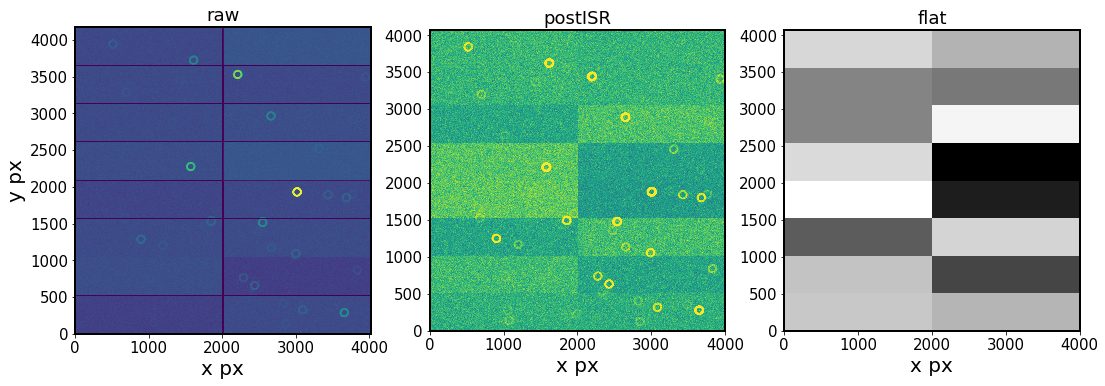

In [56]:
import lsst.daf.persistence as dafPersist

butler = dafPersist.Butler(input_dir)
print(input_dir)
post = butler.get('raw', **data_id) 
imageRaw = post.image.array


repo_dir = os.path.join(input_dir, 'rerun/run1')
print(repo_dir)
butler = dafPersist.Butler(repo_dir)
post = butler.get('postISRCCD', **data_id) 
imageIsr = post.image.array

import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

fig,ax = plt.subplots(1,3,figsize=(18,6))


ax[0].imshow(np.log10(imageRaw.T), origin='lower',vmin=3.0,vmax = 3.3)
ax[1].imshow(np.log10(imageIsr.T), origin='lower',vmin=2.2,vmax = 2.6)
ax[2].imshow(flat.T, origin='lower',cmap='Greys')
ax[0].set_title('raw')
ax[1].set_title('postISR')
ax[2].set_title('flat')
ax[0].set_ylabel('y px')
for i in range(3):
    ax[i].set_xlabel('x px')


This shows that if we flipped the flat the orientation would be correct. Belowe we don't do the transpose, just the actual orientation 'as-is' to illustrate what needs to be done (normally we have to do`plt.imshow(image.T, origin='lower') ` to properly display any `raw` or `postISR` images

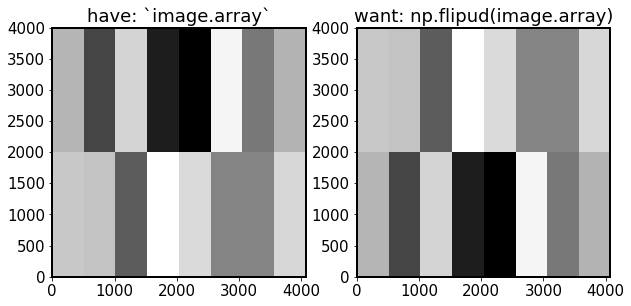

In [10]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
img = exp.image.array
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(img, origin='lower',cmap='Greys')
ax[0].set_title('have: `image.array`')

img2  = np.flipud(img)
ax[1].set_title('want: np.flipud(image.array)')
ax[1].imshow(img2, origin='lower', cmap='Greys')

I make that change in  `makeGainImages.py`  by adding a line:

    oldImageArray = image.array.copy()
    image.array[:] = np.flipud(oldImageArray)
    
like below:

In [11]:
from lsst.obs.lsst.phosim import PhosimMapper
import lsst.afw.image as afwImage

# we make example flat for R22_S00 sensor for comcam 
detector_list = ["R22_S00"]#, "R22_S01", "R22_S02", "R22_S10", "R22_S11",
                # "R22_S12", "R22_S20", "R22_S21", "R22_S22"]
camera = PhosimMapper().camera
ccd = camera["R22_S00"]
filt_name = 'g'
name = ccd.getName()
print(name)
CHIPID = "".join([c for c in name if c != "," and c != ":"])
CHIPID = "_".join(CHIPID.split())
image = afwImage.ImageF(ccd.getBBox())
for amp in ccd:
    subim = afwImage.ImageF(image, amp.getBBox())
    subim[:] = 1/amp.getGain()
    print(amp.getName(), amp.getGain())

# need to flip the image to match the result of phosim repackager... 
oldImageArray = image.array
image.array[:] = np.flipud(oldImageArray)

expInfo = afwImage.ExposureInfo()
inFilter = afwImage.Filter(filt_name)
expInfo.setFilter(inFilter)
exp = afwImage.ExposureF(afwImage.MaskedImageF(image), expInfo)
md = exp.getMetadata()
md.set('CHIPID', CHIPID)
# Set place holder date
md.set('MJD-OBS', 53005.0)

R22_S00
C10 1.719
C11 1.716
C12 1.653
C13 1.78
C14 1.735
C15 1.678
C16 1.678
C17 1.732
C07 1.705
C06 1.671
C05 1.764
C04 1.606
C03 1.622
C02 1.729
C01 1.641
C00 1.706


This achieves the  correct orientation. Show this flat:

Text(0.5, 1.0, 'R22_S00')

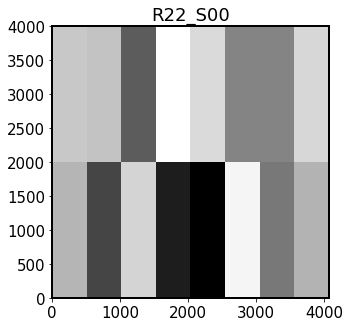

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(exp.image.array, origin='lower',cmap='Greys')
ax.set_title(name)

That change was implemented as a following PR to `phosim_utils`:  https://github.com/lsst-dm/phosim_utils/pull/10

Make new flats with that code: 

In [57]:

from lsst.obs.lsst.phosim import PhosimMapper
import lsst.afw.image as afwImage

from datetime import datetime
def makeGainImagesNew(just_wfs=False, detector_list=None):

    if (just_wfs is True) and (detector_list is not None):
        raise RuntimeError("--just_wfs and --detector_list are exclusive.")

    camera = PhosimMapper().camera
    if just_wfs:
        ccd_list = [camera[name] for name in ["R00_S22", "R04_S20", "R44_S00", "R40_S02"]]
    elif (detector_list is not None):
        ccd_list = [camera[name] for name in detector_list]
    else:
        ccd_list = camera

    for filt_name in 'ugrizy':
        for ccd in ccd_list:
            name = ccd.getName()
            # I'm not sure how to deal with the split chips yet.
            if 'A' in name or 'B' in name:
                continue
            print(name)
            CHIPID = "".join([c for c in name if c != "," and c != ":"])
            CHIPID = "_".join(CHIPID.split())
            image = afwImage.ImageF(ccd.getBBox())
            for amp in ccd:
                subim = afwImage.ImageF(image, amp.getBBox())
                subim[:] = 1/amp.getGain()
                #print(amp.getName(), amp.getGain())
                
            # need to flip the image to match the result of phosim repackager... 
            oldImageArray = image.array.copy()
            image.array[:] = np.flipud(oldImageArray)

            expInfo = afwImage.ExposureInfo()
            inFilter = afwImage.Filter(filt_name)
            expInfo.setFilter(inFilter)
            exp = afwImage.ExposureF(afwImage.MaskedImageF(image), expInfo)
            md = exp.getMetadata()
            md.set('CHIPID', CHIPID)
            # Set place holder date
            md.set('MJD-OBS', 53005.0)
            md.set('OBSTYPE', 'flat')
            # arbitrary for flats
            md.set('EXPTIME', 100)
            # need to be able to specify any filter
            md.set('CALDATE', 53005.0)
            # Add the CALIB_ID header card
            md.set('CALIB_ID', 'raftName=%s detectorName=%s detector=%i filter=%s calibDate=%s' %
                   (CHIPID.split('_')[0], CHIPID.split('_')[1], ccd.getId(), filt_name, datetime.now()))
            exp.setMetadata(md)
            exp.writeFits("%(name)s_%(filter)s.fits"%({'name': CHIPID, 'filter': filt_name}))




In [58]:
os.getcwd()

'/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/fake_flats'

In [59]:
import numpy as np 
# the following is from baseComCamLoop.py 
# https://github.com/lsst-ts/ts_phosim/blob/25ac8cdb8d8be394c18e16e66d291fecd1e3922d/notebooks/analysis_scripts/baseComcamLoop.py#L689
outputDir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/'
fakeFlatDirName = "fake_flats"
fakeFlatDir = os.path.join(outputDir, fakeFlatDirName)
if (not os.path.exists(fakeFlatDir)):    
    os.makedirs(fakeFlatDir)
    
# record where we are 
currWorkDir = os.getcwd()

# move to fake flat dir 
os.chdir(fakeFlatDir)
detector_list = ["R22_S00", "R22_S01", "R22_S02", "R22_S10", "R22_S11",
          "R22_S12", "R22_S20", "R22_S21", "R22_S22"]
makeGainImagesNew(detector_list=detector_list)

# return to the original dir 
os.chdir(currWorkDir)

R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22
R22_S00
R22_S01
R22_S02
R22_S10
R22_S11
R22_S12
R22_S20
R22_S21
R22_S22


In [11]:
print(fakeFlatDir)

/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/fake_flats


Removing the previously ingested calibs:

In [60]:
from lsst.ts.wep.Utility import runProgram
command = "rm"
argstring ="-rf %s"%(os.path.join(input_dir,'flat'))
runProgram(command,argstring=argstring)

In [61]:
#Remove the old calibs registry : 
command = "rm"
argstring="-rf %s"%os.path.join(input_dir,'calibRegistry.sqlite3')
runProgram(command,argstring=argstring)

Ingesting these new calibs:

In [62]:
calibFiles = os.path.join(fakeFlatDir, "*")
command = "ingestCalibs.py"

argstring = "%s %s --validity 99999 --output %s" % (
            input_dir, calibFiles, input_dir)
import subprocess


cmd = ['ingestCalibs.py',input_dir, calibFiles, '--validity 99999',
        '--output', input_dir]

a = ''
for x in cmd:
    a += ' %s '% x
print('The command run by subprocess is ')
print('\n',a)

proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = proc.communicate()[0]


The command run by subprocess is 

  ingestCalibs.py  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/fake_flats/*  --validity 99999  --output  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/ 


## 2 : ISR with new flats

Using these new flats to do the ISR. Make a settings file (same as before) :

In [63]:
isrSettings = {'doBias':False, 'doDark':False,
               'doFlat':True, 'doFringe':False, 
               'doDefect':False,
              }
content = ""
for setting in isrSettings.keys():
    content += "config.isr.%s=%s\n"%(setting,str(isrSettings[setting]))
isrConfigFname =  'isr_config2.py'
config_path = os.path.join(input_dir,isrConfigFname)

# Write into file
fid = open(config_path, "w")
fid.write(content)
fid.close()



Now run the ISR task :

In [1]:
import os 

In [15]:
isrConfigFname =  'isr_config2.py'
input_dir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/'
config_path = os.path.join(input_dir,isrConfigFname)



In [64]:
import subprocess

cmd = ['runIsr.py',input_dir, '--id', '--rerun=run2',
        '--configfile', config_path,
        '--no-versions',]# '--clobber-config']

a = ''
for x in cmd:
    a += ' %s '% x
print('The command run by subprocess is ')
print('\n',a)

proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = proc.communicate()[0]

The command run by subprocess is 

  runIsr.py  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/  --id  --rerun=run2  --configfile  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/isr_config2.py  --no-versions 


Show now the raw and postIsr image : 

/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/


Ignoring Error calculating property 'boresight_airmass' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['AIRMASS'] in header"
Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['TEMPERA'] in header"
Ignoring Error calculating property 'pressure' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['PRESS'] in header"


/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/rerun/run2


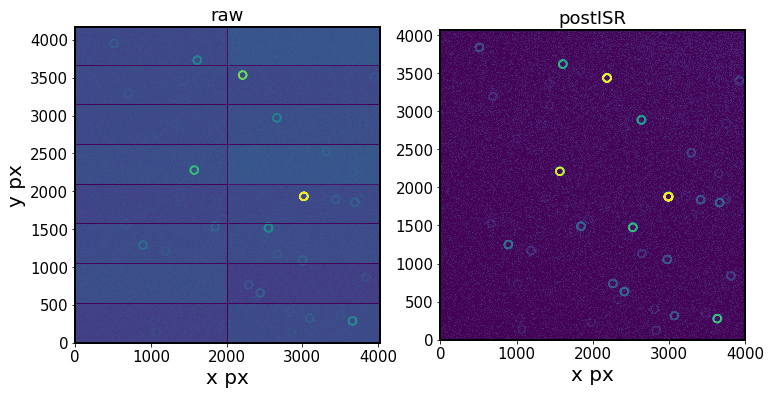

In [83]:
import lsst.daf.persistence as dafPersist
input_dir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/'

data_id = {'expId': 9006001 , 'filter':'g', 'raftName':'R22',  
           'detectorName': 'S00'}

butler = dafPersist.Butler(input_dir)
print(input_dir)
post = butler.get('raw', **data_id) 
imageRaw = post.image.array


repo_dir = os.path.join(input_dir, 'rerun/run2')
print(repo_dir)
butler = dafPersist.Butler(repo_dir)
post = butler.get('postISRCCD', **data_id) 
imageIsr = post.image.array


%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(np.log10(imageRaw.T), origin='lower',vmin=3.0,vmax = 3.3)
ax[1].imshow(np.log10(imageIsr.T), origin='lower',vmin=2.45,vmax = 3)
ax[0].set_title('raw')
ax[1].set_title('postISR')
ax[0].set_ylabel('y px')
for i in range(2):
    ax[i].set_xlabel('x px')




That's much better! The difference in pixel values wouldn't be much, because we just changed the orientation, but it looks better.

In [89]:
repo_dir = os.path.join(input_dir, 'rerun/run1')
butler = dafPersist.Butler(repo_dir)
post = butler.get('postISRCCD', **data_id) 
imageIsr1 = post.image.array

repo_dir = os.path.join(input_dir, 'rerun/run2')
butler = dafPersist.Butler(repo_dir)
post = butler.get('postISRCCD', **data_id) 
imageIsr2 = post.image.array

print('before:', np.median(np.ravel(imageIsr1)), 'after:', np.median(np.ravel(imageIsr2)))

before: 288.66492 after: 288.64972


Now instead of creating master biases, show that this value of background could go down if we subtract the bias by hand:

### By-hand ISR using the bias and gain from raw image header

    corrected = (image-bias)*gain

In [91]:
rawDir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/iter0/img/extra'
# find the names of the raw amp files 
rawFiles = os.listdir(rawDir)
raw =[]
for x in rawFiles:
    if x.startswith('lsst_a_9006001'):
        raw.append(x)

In [95]:
# iterate over raw amp files  : update by subtracting bias    
#for fname in raw:
fname = raw[0]
hdul = fits.open(os.path.join(rawDir, fname))#, mode='update')

hdul[1].data

array([[973, 976, 976, ..., 973, 976, 971],
       [973, 971, 975, ..., 986, 971, 984],
       [974, 971, 979, ..., 976, 979, 970],
       ...,
       [972, 980, 975, ..., 979, 976, 975],
       [979, 969, 980, ..., 980, 974, 974],
       [974, 981, 977, ..., 976, 971, 969]], dtype=uint32)

Subtract bias and multiply by gain :

In [98]:

# subtract bias for each amp
for i in range(1,len(hdul)): # this iterates over 16 amps 
    bias =  hdul[i].header['Bias']
    #chipid = hdul[i].header['ampid']
    #print(chipid, bias)
    new_data = np.array(hdul[i].data, dtype=np.float)
    new_data -= bias
        
    hdul[i].data = new_data*hdul[i].header['Gain']
    
#hdul.flush()

In [100]:
np.median(hdul[1].data)

282.85309399999994

Next one would ingest the updated raw images, and doIsr with doFlat = False (and everything else False). It does what we would expect (correct ISR). So next I test whether doOverscan returns similar Gain values to those in raw image headers

Show the result with just `config.isr.doOverscan=True`. What `overscan` does:
- measures certain value of the overscan region, eg. 'MEAN',  clipped mean 'MEANCLIP', or 'MEDIAN'
- fits a function to the overscan region if needed - that's the 'overscan model'
- subtracts the `offImage` - the overscan image - from the amp image: https://github.com/lsst/ip_isr/blob/9bcb941892af4677dfbb1e4d5eb8c70cdce97b90/python/lsst/ip/isr/overscan.py#L171

            ampImage -= offImage 

the stats displayed are 

    if isinstance(overscanResults.overscanFit, float):
        qaMedian = overscanResults.overscanFit
        qaStdev = float("NaN")
        
    self.log.debug("  Overscan stats for amplifer %s: %f +/- %f",
                                       amp.getName(), qaMedian, qaStdev)
   
where 

    overscanFit=overscanModel 
    
i.e.  an element of a structure returned by ip_isr/python/lsst/ip/isr/overscan.py, `OverscanCorrectionTask.run()`

and by default, `self.config.fitType` is `MEDIAN`, so 

    if self.config.fitType in ('MEAN', 'MEANCLIP', 'MEDIAN'):
            overscanResult = self.measureConstantOverscan(overscanImage)
            overscanValue = overscanResult.overscanValue
            offImage = overscanValue
            overscanModel = overscanValue
            
and what it does is calculate the median of the overscan image:
    
    self.measureConstantOverscan(overscanImage):
    image = overscanImage
    if self.config.fitType == 'MEDIAN':
        calcImage = self.integerConvert(image)
        overscanValue = afwMath.makeStatistics(calcImage, fitType, self.statControl).getValue()

### 3: Running ISR with doOverscan = True 

In [102]:
isrSettings = {'doBias':False, 'doDark':False,
               'doFlat':False, 'doFringe':False, 
               'doDefect':False,'doOverscan':True
              }
content = ""
for setting in isrSettings.keys():
    content += "config.isr.%s=%s\n"%(setting,str(isrSettings[setting]))
isrConfigFname =  'isr_config3.py'
config_path = os.path.join(input_dir,isrConfigFname)

# Write into file
fid = open(config_path, "w")
fid.write(content)
fid.close()




In [103]:
import subprocess

cmd = ['runIsr.py',input_dir, '--id', '--rerun=run3',
        '--configfile', config_path,
        '--no-versions',]# '--clobber-config']

a = ''
for x in cmd:
    a += ' %s '% x
print('The command run by subprocess is ')
print('\n',a)

proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
output = proc.communicate()[0]

The command run by subprocess is 

  runIsr.py  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/  --id  --rerun=run3  --configfile  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/isr_config3.py  --no-versions 


In [104]:
#First store the bias, gain, ampid for all ampsin that sensor in **pre-ISR raw fits file** :
    
from astropy.table import Table 
import astropy.io.fits as fits

expId = '9006001'
raftName='R22'
detectorName = 'S00'
detNum = '90'


sensor = '%s_%s'%(raftName, detectorName)
data_dir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/'


raw_dir = os.path.join(data_dir, 'iter0/img/extra')
fname = 'lsst_a_%s_f1_%s_E000.fits'%(expId, sensor)
hdulr = fits.open(os.path.join(raw_dir, fname))
sensCol = []
biasCol = []
gainCol = []
ampCol = []
for i in range(1,len(hdulr)): # this iterates over 16 amps 
        bias =  hdulr[i].header['Bias']
        gain = hdulr[i].header['Gain']
        chipid = hdulr[i].header['ampid']
        print(chipid, bias, gain)
        sensCol.append(sensor)
        biasCol.append(bias)
        gainCol.append(gain)
        ampCol.append(chipid)
rawSensorData  = Table(data=[sensCol,biasCol,gainCol, ampCol],
                      names=['sensor', 'biasRaw', 'gainRaw', 'amp'])


# Then add to this column the median overscan value  from the **postISR CCD**- 
# the 'ISC_OSCAN_LEVEL' in the postISRCCD header, which is subtracted from the image just like bias would:


postIsr_dir = os.path.join(input_dir, 'rerun/run3/postISRCCD/0%s-g/%s/'%(expId,raftName))
#os.listdir(postIsr_dir)
fname = 'postISRCCD_0%s-g-%s-%s-det0%s.fits'%(expId, raftName, detectorName, detNum)
hdul = fits.open(os.path.join(postIsr_dir, fname))

oscanMedian = []
for ampId in rawSensorData['amp']:
    headerRow =  'ISR_OSCAN_LEVEL%s'%ampId
    oscanLevel = hdul[0].header[headerRow]
    print(headerRow, oscanLevel)
    oscanMedian.append(oscanLevel)
    
rawSensorData['oscanMedian'] = oscanMedian

print(rawSensorData[['sensor', 'biasRaw', 'oscanMedian']])

# --> We see that `biasRaw` and `oscanMedian` above are close but not the same ... 

C00 976.201 1.706
C01 1007.37 1.641
C02 1007.85 1.729
C03 980.433 1.622
C04 1000.66 1.606
C05 1005.32 1.764
C06 996.786 1.671
C07 996.103 1.705
C17 1030.65 1.732
C16 991.159 1.678
C15 1007.48 1.678
C14 1037.0 1.735
C13 1004.57 1.78
C12 1001.09 1.653
C11 971.052 1.716
C10 1005.46 1.719
ISR_OSCAN_LEVELC00 1004.05202020202
ISR_OSCAN_LEVELC01 971.010362694301
ISR_OSCAN_LEVELC02 1000.0198693522
ISR_OSCAN_LEVELC03 1003.01597938144
ISR_OSCAN_LEVELC04 1035.99261083744
ISR_OSCAN_LEVELC05 1007.05747436589
ISR_OSCAN_LEVELC06 991.02762119504
ISR_OSCAN_LEVELC07 1029.97164948454
ISR_OSCAN_LEVELC17 995.96318537859
ISR_OSCAN_LEVELC16 995.92230644288
ISR_OSCAN_LEVELC15 1005.99440389294
ISR_OSCAN_LEVELC14 999.010822510823
ISR_OSCAN_LEVELC13 978.967993544917
ISR_OSCAN_LEVELC12 1007.03102453102
ISR_OSCAN_LEVELC11 1006.93614830072
ISR_OSCAN_LEVELC10 975.978544269419
 sensor biasRaw   oscanMedian   
------- ------- ----------------
R22_S00 976.201 1004.05202020202
R22_S00 1007.37 971.010362694301
R22_S00 10

We see that the value of bias in the raw image file is very close to that deduced during the overscan process. Thus add `doOverscan` to the ISR process together with `doFlats`:

## 4: ISR with doOverscan and doFlats

In [105]:
isrSettings = {'doBias':False, 'doDark':False,
               'doFlat':True, 'doFringe':False, 
               'doDefect':False,'doOverscan':True
              }
content = ""
for setting in isrSettings.keys():
    content += "config.isr.%s=%s\n"%(setting,str(isrSettings[setting]))
isrConfigFname =  'isr_config4.py'
config_path = os.path.join(input_dir,isrConfigFname)

# Write into file
fid = open(config_path, "w")
fid.write(content)
fid.close()

In [106]:
import subprocess

cmd = ['runIsr.py',input_dir, '--id', '--rerun=run4',
        '--configfile', config_path,
        '--no-versions',]# '--clobber-config']

a = ''
for x in cmd:
    a += ' %s '% x
print('The command run by subprocess is ')
print('\n',a)

# proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
# output = proc.communicate()[0]

The command run by subprocess is 

  runIsr.py  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/  --id  --rerun=run4  --configfile  /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/isr_config4.py  --no-versions 


Show the result: 

/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/rerun/run4


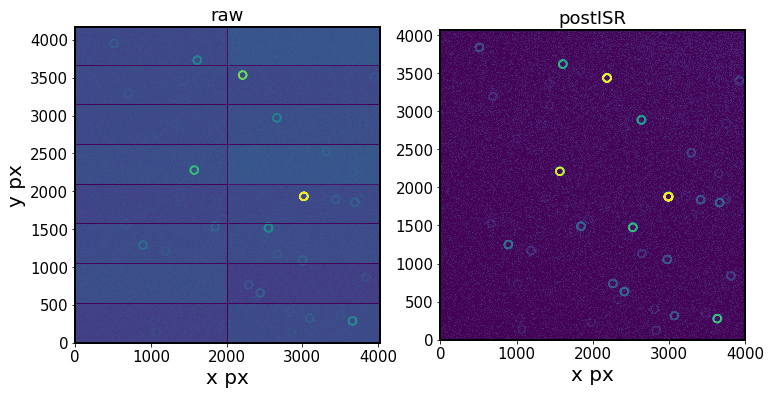

In [108]:
import lsst.daf.persistence as dafPersist
input_dir = '/data/epyc/users/suberlak/Commissioning/aos/\
ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_high_full_2020_24_NEW/input/'

data_id = {'expId': 9006001 , 'filter':'g', 'raftName':'R22',  
           'detectorName': 'S00'}


repo_dir = os.path.join(input_dir, 'rerun/run4')
print(repo_dir)
butler = dafPersist.Butler(repo_dir)
post = butler.get('postISRCCD', **data_id) 
imageIsr = post.image.array


%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].imshow(np.log10(imageRaw.T), origin='lower',vmin=3.0,vmax = 3.3)
ax[1].imshow(np.log10(imageIsr.T), origin='lower',vmin=2.45,vmax = 3)
ax[0].set_title('raw')
ax[1].set_title('postISR')
ax[0].set_ylabel('y px')
for i in range(2):
    ax[i].set_xlabel('x px')





Apart from changing the way that flats are made in `phosim_utils`, the suggestion to use `doOverscan` necessitates changes to `ts_wep`, specifically add setting for `doOverscan` https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/CamIsrWrapper.py and https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py (default `_doIsr` setting to add `doOverscan=True`). 